In [80]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator

from sklearn import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score

from sklearn.model_selection import train_test_split, cross_val_predict, KFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('data_clean.csv', index_col=0)
data.shape

(2943, 10)

In [3]:
data.head()

,molecule_chembl_id,Ki,units,pKi,smiles,molecular_weight,n_hba,n_hbd,logp,passed
0,CHEMBL132806,57.0,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,429.191323,9,1,3.9613,True
1,CHEMBL336217,42.0,nM,7.38,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...,479.206973,9,1,5.1145,True
2,CHEMBL134566,60.0,nM,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,477.191323,9,1,4.5480,True
3,CHEMBL435022,38.0,nM,7.42,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...,445.186238,10,1,3.7976,True
4,CHEMBL341376,423.0,nM,6.37,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1,373.128723,9,1,2.4522,True


In [4]:
threshold = data['pKi'].mean()
threshold

6.8835032279986414

In [5]:
def set_activity(ki_value):
    if ki_value >= threshold:
        return 1.0
    else:
        return 0.0

In [6]:
data = data[['molecule_chembl_id', 'Ki', 'pKi', 'smiles']]
data.shape

(2943, 4)

In [7]:
data['activity'] = data['pKi'].apply(set_activity)

In [8]:
data['maccs'] = data['smiles'].apply(lambda x: MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)))

In [9]:
len(data['maccs'].unique())

2942

In [10]:
data.head()

,molecule_chembl_id,Ki,pKi,smiles,activity,maccs
0,CHEMBL132806,57.0,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL336217,42.0,7.38,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL134566,60.0,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL435022,38.0,7.42,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL341376,423.0,6.37,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


I have found earlier this way to make np.array from MACCSKeys column

In [11]:
X_all = np.stack(data['maccs'])
X_all, X_all.shape

(array([[0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 1, 0]]),
 (2943, 167))

In [12]:
X_all[0] == data.iloc[0]['maccs']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [13]:
y_all = data['activity'].to_numpy()
y_all

array([1., 1., 1., ..., 0., 1., 0.])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In [15]:
splits = [X_train, X_test, y_train, y_test]

In [16]:
forest_cf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42, n_jobs=-1)

In [17]:
forest_cf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=42)

In [18]:
y_pred = forest_cf.predict(X_test)

In [19]:
len(y_test)

589

Number of correct and inocrect predictions

In [20]:
sum(y_pred == y_test), sum(y_pred != y_test)

(462, 127)

Correct predictions percentage

In [21]:
sum(y_pred == y_test) / len(y_test) * 100

78.43803056027164

In [22]:
rf_confusion_matrix = confusion_matrix(y_test, y_pred)
rf_confusion_matrix

array([[249,  60],
       [ 67, 213]], dtype=int64)

In this case, we have:
 - 249 true negatives,
 - 60 false positives,
 - 67 false negatives,
 - 213 true positives

Precission and recall score

When model predicts that the compound is active, it is correct in 78.02% cases

In [23]:
precision_score(y_test, y_pred)

0.7802197802197802

Model detects only 76.07% active compounds

In [24]:
recall_score(y_test, y_pred)

0.7607142857142857

In [25]:
f1_score(y_test, y_pred)

0.7703435804701627

In [26]:
def plot_roc_curves_for_models(models, test_x, test_y):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")

In [27]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [28]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In [29]:
models = [
    {'label': 'model_RF', 'model': forest_cf}
]

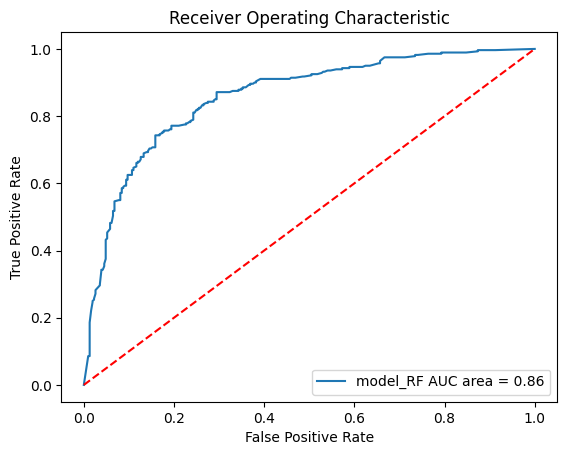

In [30]:
plot_roc_curves_for_models(models, X_test, y_test)

In [31]:
rf_pipeline = Pipeline(
    [('random_forest', RandomForestClassifier(random_state=42, n_jobs=-1))]
)

In [32]:
param_gird = [
    {'random_forest__criterion': ['gini', 'entropy', 'log_loss']},
    {'random_forest__n_estimators': [50, 100, 200, 500, 1000]}
]

In [33]:
rf_grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_gird, cv=3, n_jobs=-1, scoring='precision')

In [34]:
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('random_forest',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid=[{'random_forest__criterion': ['gini', 'entropy',
                                                       'log_loss']},
                         {'random_forest__n_estimators': [50, 100, 200, 500,
                                                          1000]}],
             scoring='precision')

In [35]:
rf_grid_search.best_estimator_

Pipeline(steps=[('random_forest',
                 RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                        random_state=42))])

In [36]:
model_rf = clone(rf_grid_search.best_estimator_)

In [37]:
model_rf.get_params()

{'memory': None,
 'steps': [('random_forest',
   RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42))],
 'verbose': False,
 'random_forest': RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42),
 'random_forest__bootstrap': True,
 'random_forest__ccp_alpha': 0.0,
 'random_forest__class_weight': None,
 'random_forest__criterion': 'gini',
 'random_forest__max_depth': None,
 'random_forest__max_features': 'sqrt',
 'random_forest__max_leaf_nodes': None,
 'random_forest__max_samples': None,
 'random_forest__min_impurity_decrease': 0.0,
 'random_forest__min_samples_leaf': 1,
 'random_forest__min_samples_split': 2,
 'random_forest__min_weight_fraction_leaf': 0.0,
 'random_forest__monotonic_cst': None,
 'random_forest__n_estimators': 1000,
 'random_forest__n_jobs': -1,
 'random_forest__oob_score': False,
 'random_forest__random_state': 42,
 'random_forest__verbose': 0,
 'random_forest__warm_start': False}

In [38]:
model_rf.fit(X_train, y_train)

Pipeline(steps=[('random_forest',
                 RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                        random_state=42))])

In [39]:
model_performance(model_rf, X_test, y_test)

Sensitivity: 0.76
Specificity: 0.79
AUC: 0.86


(0.7792869269949066,
 0.7642857142857142,
 0.7928802588996764,
 0.8575531668978271)

In [40]:
models = [
    {'label': 'model_RF',
     'model': model_rf}
]

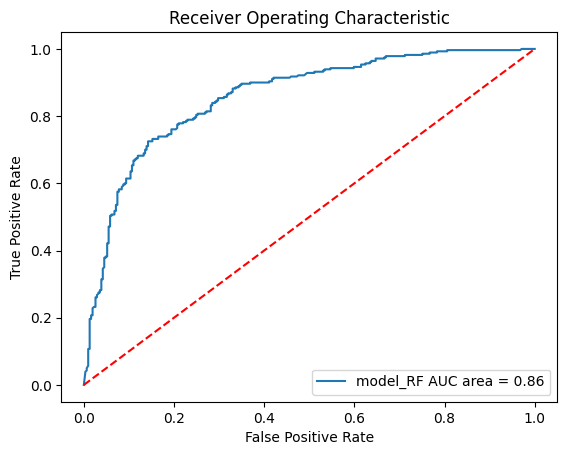

In [41]:
plot_roc_curves_for_models(models, X_test, y_test)

In [42]:
model_rf_grid = RandomForestClassifier(random_state=42, n_jobs=-1)

In [43]:
param_grid_1 = {'n_estimators': [50, 100, 150, 200, 500, 1000, 1500, 2000],
                'criterion': ['gini', 'entropy', 'log_loss']}

In [44]:
grid_1 = GridSearchCV(model_rf_grid, param_grid=param_grid_1, scoring='f1', cv=3, n_jobs=-1)

In [45]:
grid_1.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [50, 100, 150, 200, 500, 1000, 1500,
                                          2000]},
             scoring='f1')

In [46]:
best_rf = clone(grid_1.best_estimator_)

In [47]:
best_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [48]:
best_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=42)

In [49]:
models = [
    {'label': 'model_RF',
     'model': best_rf}
]

In [50]:
svc = SVC(random_state=42)

In [51]:
param_grid_svc = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [1, 10, 100],
    'gamma': ['auto', 0.1, 0.01],
    'probability': [True, False]
}

In [52]:
grid_svc = GridSearchCV(svc, param_grid=param_grid_svc, scoring='accuracy', cv=3, n_jobs=-1)

In [53]:
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'gamma': ['auto', 0.1, 0.01],
                         'kernel': ['rbf', 'sigmoid'],
                         'probability': [True, False]},
             scoring='accuracy')

In [54]:
model_svc = clone(grid_svc.best_estimator_)

In [55]:
model_svc.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [56]:
model_svc.fit(X_train, y_train)

SVC(C=1, gamma=0.1, probability=True, random_state=42)

In [57]:
models.append(
    {'label': 'model_SVC',
     'model': model_svc}
)

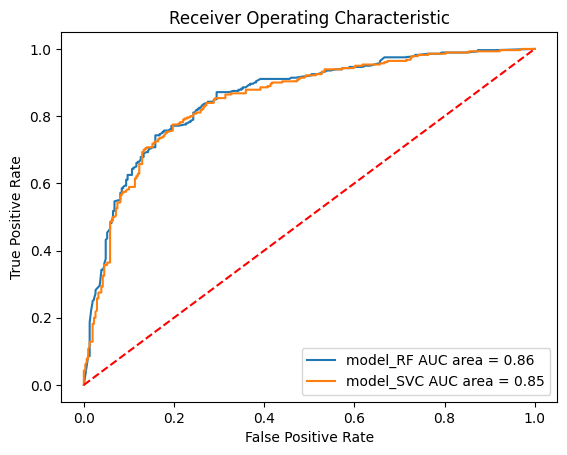

In [58]:
plot_roc_curves_for_models(models, X_test, y_test)

In [59]:
model_performance(model_svc, X_test, y_test)

Sensitivity: 0.76
Specificity: 0.80
AUC: 0.85


(0.7826825127334465,
 0.7607142857142857,
 0.8025889967637541,
 0.8495203421174295)

In [60]:
ann = MLPClassifier(max_iter=10_000, random_state=42)

In [61]:
param_grid_ann = {
    'hidden_layer_sizes': [(5, 3), (8, 5, 3), (16, 8, 5, 3)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam']
}

In [62]:
grid_ann = GridSearchCV(ann, param_grid=param_grid_ann, scoring='accuracy', n_jobs=-1, cv=3)

In [63]:
grid_ann.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=10000, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(5, 3), (8, 5, 3),
                                                (16, 8, 5, 3)],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='accuracy')

In [64]:
model_ann = clone(grid_ann.best_estimator_)

In [65]:
model_ann.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (16, 8, 5, 3),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 10000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [66]:
model_ann.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(16, 8, 5, 3), max_iter=10000, random_state=42)

In [67]:
models.append(
    {'label': 'model_ANN',
     'model': model_ann}
)

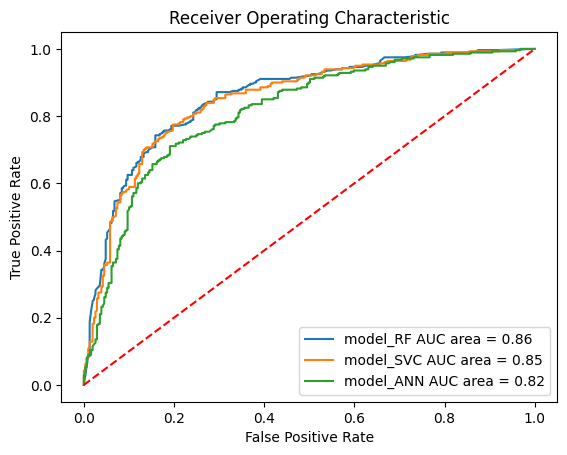

In [68]:
plot_roc_curves_for_models(models, X_test, y_test)

In [69]:
model_performance(model_ann, X_train, y_train)

Sensitivity: 0.93
Specificity: 0.86
AUC: 0.96


(0.8963466440101954, 0.9335038363171355, 0.859441151566469, 0.9565802096710274)

In [70]:
for model in models:
    print(model['label'])
    print(model_training_and_validation(model['model'], model['label'], splits))
    print()

model_RF
Sensitivity: 0.76
Specificity: 0.81
AUC: 0.86
(0.7843803056027164, 0.7607142857142857, 0.8058252427184466, 0.8572295423023577)

model_SVC
Sensitivity: 0.76
Specificity: 0.80
AUC: 0.85
(0.7826825127334465, 0.7607142857142857, 0.8025889967637541, 0.8495203421174295)

model_ANN
Sensitivity: 0.76
Specificity: 0.71
AUC: 0.82
(0.7368421052631579, 0.7642857142857142, 0.7119741100323624, 0.8156726768377254)



In [71]:
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3 ,fpSize=2048)
data['morgan'] = data['smiles'].apply(lambda x: morgan_gen.GetFingerprint(Chem.MolFromSmiles(x)))

In [72]:
data['morgan']

0       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
2938    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2939    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2940    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2941    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2942    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
Name: morgan, Length: 2943, dtype: object

In [73]:
Xmorgan_all = np.stack(data['morgan'])
Xmorgan_all

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [74]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(Xmorgan_all, y_all, test_size=0.2, random_state=42)
splits = [X_train_1, X_test_1, y_train_1, y_test_1]

In [75]:
for model in models:
    print(model['label'])
    print(model_training_and_validation(model['model'], model['label'], splits))
    print()

model_RF
Sensitivity: 0.80
Specificity: 0.80
AUC: 0.88
(0.797962648556876, 0.7964285714285714, 0.7993527508090615, 0.8831079519186316)

model_SVC
Sensitivity: 0.77
Specificity: 0.83
AUC: 0.86
(0.797962648556876, 0.7678571428571429, 0.8252427184466019, 0.8550797503467406)

model_ANN
Sensitivity: 0.81
Specificity: 0.76
AUC: 0.87
(0.7843803056027164, 0.8071428571428572, 0.7637540453074434, 0.8730004623208507)



In [79]:
SEED = 22

In [81]:
data.columns

Index(['molecule_chembl_id', 'Ki', 'pKi', 'smiles', 'activity', 'maccs',
       'morgan'],
      dtype='object')

In [82]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index]['morgan'].tolist()
        train_y = df.iloc[train_index]['activity'].tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index]['morgan'].tolist()
        test_y = df.iloc[test_index]['activity'].tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

In [83]:
N_FOLDS = 5

In [84]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], data, n_folds=N_FOLDS)



model_RF
Mean accuracy: 0.82 	and std : 0.02 
Mean sensitivity: 0.82 	and std : 0.02 
Mean specificity: 0.82 	and std : 0.02 
Mean AUC: 0.90 	and std : 0.01 
Time taken : 12.77s


model_SVC
Mean accuracy: 0.80 	and std : 0.01 
Mean sensitivity: 0.76 	and std : 0.02 
Mean specificity: 0.85 	and std : 0.02 
Mean AUC: 0.87 	and std : 0.02 
Time taken : 120.91s


model_ANN
Mean accuracy: 0.80 	and std : 0.01 
Mean sensitivity: 0.79 	and std : 0.03 
Mean specificity: 0.80 	and std : 0.03 
Mean AUC: 0.88 	and std : 0.01 
Time taken : 36.29s

